# Linear Leios DeltaQ analysis

*Linear Leios* is a protocol extending *Ouroboros Praos* to increase throughput. The protocol is specified in __[CIP0164](https://github.com/cardano-scaling/CIPs/tree/leios/CIP-0164)__ and the development is documented at __[Leios - Cardano Scaling](https://leios.cardano-scaling.org/)__. 

The DeltaQ analysis of *Linear Leios* is based on the document
* __[Supporting information for modeling Linear Leios](https://github.com/input-output-hk/ouroboros-leios/blob/main/analysis/deltaq/linear-leios-preliminaries.md)__

and the analysis of *Ouroboros Praos*
* __[Mind Your Outcomes: Quality-Centric Systems Development, 2022](https://iohk.io/en/research/library/papers/mind-your-outcomes-the-dqsd-paradigm-for-quality-centric-systems-development-and-its-application-to-a-blockchain-case-study/)__
* __[Modelling Block Diffusion in Cardano using ∆Q](https://github.com/IntersectMBO/cardano-formal-specifications/tree/main/src/performance/)__

In [1]:
{-# LANGUAGE FlexibleContexts #-}
{-# LANGUAGE GADTs #-}

import Data.Bifunctor (second)
import Data.Ratio
import Data.Tuple (swap)
import Text.Printf

import DeltaQ
import Numeric.Function.Piecewise

import Graphics.Rendering.Chart.Backend.Cairo
import Graphics.Rendering.Chart.Easy
import Graphics.Rendering.Chart.Renderable

import Statistics.Distribution
import Statistics.Distribution.Exponential
import Statistics.Distribution.Normal

# Linear Leios
Feasible protocol parameters for *Linear Leios* as mentioned in the CIP are as follows

In [2]:
lHdr  = 1
lVote = 4
lDiff = 7

Set the number of *stake pools* for the analysis

In [3]:
nPools = 2500

and the *active slot coefficient*, i.e. the rate of block production

In [4]:
lambda = 0.05

## RB diffusion

Block diffusion from Praos<br>
**TODO**: Use results from Leios topology checker tool instead

In [5]:
data BlockSize = B64 | B256 | B512 | B1024 | B2048
    deriving (Show, Eq)
    
blockSizes :: [BlockSize]
blockSizes = [B64, B256, B512, B1024, B2048]

In [6]:
short :: BlockSize -> DQ
short B64     = wait 0.024
short B256    = wait 0.047
short B512    = wait 0.066
short B1024   = wait 0.078
short B2048   = wait 0.085

In [7]:
medium :: BlockSize -> DQ
medium B64    = wait 0.143
medium B256   = wait 0.271
medium B512   = wait 0.332
medium B1024  = wait 0.404
medium B2048  = wait 0.469

In [8]:
long :: BlockSize -> DQ
long B64      = wait 0.531
long B256     = wait 1.067
long B512     = wait 1.598
long B1024    = wait 1.598
long B2048    = wait 1.867

In [9]:
hop :: BlockSize -> DQ
hop b = choices [(1, short b), (1, medium b), (1, long b)]

In [10]:
import Control.Monad (replicateM)
import Data.Maybe (mapMaybe)
import System.Random (randomRIO)
import System.IO.Unsafe (unsafePerformIO)

reduceComplexity :: DQ -> DQ
reduceComplexity d =
  let vals = unsafePerformIO $ rand 100
  in choices $ zipWith (curry (second wait)) (map toRational vals) (mapMaybe (maybeFromEventually . qt d) vals) 
  where
    rand n = replicateM n $ randomRIO (0.00001,1)
    qt d x = fromRational <$> DeltaQ.quantile d (toRational x)

In [11]:
doSequentially :: [DQ] -> DQ
doSequentially = foldr (.>>.) (wait 0)

doAll :: [DQ] -> DQ
doAll = foldr (./\.) (wait 0)

doAny :: [DQ] -> DQ
doAny = foldr (.\/.) (wait 0)

In [12]:
hops :: Int -> BlockSize -> DQ
hops n b = doSequentially (replicate n (hop b))

## EB diffusion

DeltaQ model produced by the topology checker tool:

distance distribution in hops ([(0.0, 0.0), (1.0, 1909.0), (2.0, 3867.0), (3.0, 2826.0), (4.0, 1068.0), (5.0, 214.0), (6.0, 16.0), (7.0, 0.0)])

#### this is the main result expression
```
gossip := (near ->- (CDF[(0, 1)] 0.022773398<>0.9772266 near ->- (CDF[(0, 1)] 0.022773398<>0.9772266 near ->- (CDF[(0, 1)] 0.022773398<>0.9772266 near ->- (CDF[(0, 1)] 0.58243084<>0.41756916 near))))) ->- (CDF[(0, 1)] 0.7476325<>0.2523675 far ->- CDF[(0, 1)])
```
#### gossip is built on these outcomes that should contain send and receive actions
```
near := near_send
far := far_send
```
#### these are the extracted latencies from the topology
```
near_send := CDF[(0.0643, 0.33075), (3.8168, 0.7382), (18.0988, 0.88127), (26.712, 0.96207), (37.2126, 0.98242), (48.229, 0.98844), (54.2403, 0.99163), (67.2503, 0.99423), (73.0689, 0.99682), (81.6974, 1)]
far_send := CDF[(78.737, 0.0023), (83.8947, 0.02122), (134.1927, 0.09285), (185.3148, 0.17255), (231.64439, 0.24732), (276.2988, 0.37204), (318.3721, 0.68758), (363.1637, 0.96066), (457.63721, 0.99691), (529.08582, 1)]
```

In [13]:
hopCount = [(1, 1909), (2, 3867), (3, 2826), (4, 1068), (5, 214), (6, 16)]

In [14]:
blendedDelay' :: BlockSize -> DQ
blendedDelay' b = choices $ map (\(n , p) -> (p, hops n b)) hopCount

In [15]:
complexity $ reduceComplexity $ blendedDelay' B64

26

Copied `measuredDQ` from https://github.com/DeltaQ-SD/deltaq/issues/75#issuecomment-3334080165

In [16]:
measuredDQ :: [(Rational, Rational)]  -- ordered list of delays 
           -> DQ                      -- the delay distribution
-- we have a list of (probability, delay), ordered on the delays
measuredDQ delays = choices dataPoints
  where
    -- we add a (0, 0) point at the beginning to ensure that the first delay is always 0
    extendedData = if head delays == (0, 0) then delays else (0, 0) : delays 
    -- the weight of each point is the difference in probability
    dataPoints = 
      [(p' - p, delayComponent d' d) | ((p, d), (p', d')) <- zip extendedData (tail extendedData)]
    -- if we have two delays with the same percentage probability, we simply wait for that time
    -- otherwise we use a uniform distribution between the two delays
    delayComponent d1 d2 = if d1 == d2 then wait d1 else uniform d1 d2

In [17]:
blendedDelayMeasured :: BlockSize -> DQ
blendedDelayMeasured b =
   case b of
     B64   ->
       measuredDQ [(0.4,0.5),(0.85,1.0),(0.99,2.0),(1.0,3.0)]
     B256  ->
       measuredDQ [(0.4,0.7),(0.85,1.5),(0.99,3.0),(1.0,5.0)]
     B512  ->
       measuredDQ [(0.4,0.75),(0.85,2.0),(0.99,4.0),(1.0,8.0)]
     B1024 ->
       measuredDQ [(0.4,1),(0.85,2.5),(0.99,5.0),(1.0,10.0)]
     B2048 ->
       measuredDQ [(0.4,2.0),(0.85,3.5),(0.99,6.0),(1.0,12.5)]

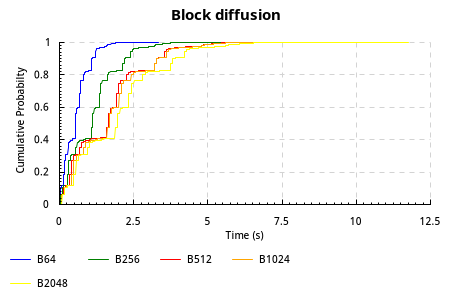

83

In [18]:
toRenderable $ plotCDFs "Block diffusion" $ zip (map show blockSizes) (map blendedDelay' blockSizes)
complexity $ blendedDelay' B64

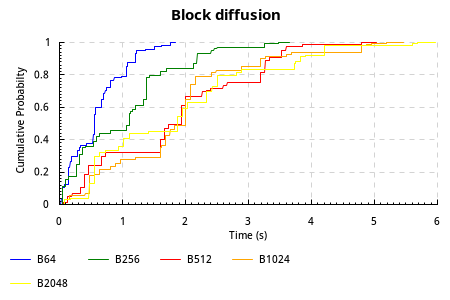

28

In [19]:
toRenderable $ plotCDFs "Block diffusion" $ zip (map show blockSizes) (map (reduceComplexity . blendedDelay') blockSizes)
complexity $ reduceComplexity $ blendedDelay' B64

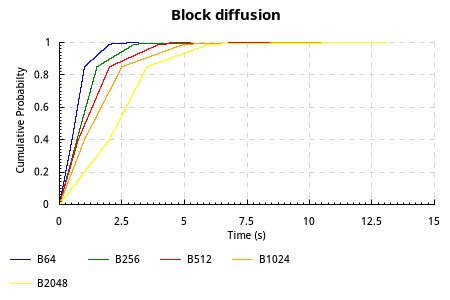

9

In [20]:
toRenderable $ plotCDFs "Block diffusion" $ zip (map show blockSizes) (map blendedDelayMeasured blockSizes)
complexity $ blendedDelayMeasured B64

In [21]:
blendedDelay :: BlockSize -> DQ
blendedDelay = reduceComplexity . blendedDelay'
-- blendedDelay = blendedDelayMeasured

In [22]:
emitRBHeader :: DQ
emitRBHeader = blendedDelay B64

fetchingRBBody :: DQ
fetchingRBBody = blendedDelay B1024

In [23]:
fetchingEBHeader :: DQ
fetchingEBHeader = blendedDelay B64

fetchingEBBody :: DQ
fetchingEBBody = blendedDelay B2048

fetchingEB :: DQ
fetchingEB = fetchingEBHeader .>>. fetchingEBBody

TODO: tx size from lognormal distribution above

TODO: 
 * How to deal with larger numbers... 
 * `checkMempool` needs a model for the mempool based on transactions (like the model in the VECTOR paper, appendix D)

In [24]:
checkMempool :: DQ
checkMempool = wait 0

The choice between the `applyTx` and `reapplyTx` depends upon whether the transaction is already present in the memory pool

* m : number of transactions in RB
* n : number of transaction references in EB

In [25]:
m = 64
n = 1024

In [26]:
applyTx :: DQ
applyTx = uniform 0.1 0.4

In [27]:
applyTxs :: DQ
applyTxs = reduceComplexity $ doAll $ replicate m applyTx

In [28]:
reapplyTx :: DQ
reapplyTx = uniform 0 0.2

In [29]:
reapplyTxs :: DQ
reapplyTxs = reduceComplexity $ doAll $ replicate n reapplyTx

Fetching transactions in parallel in chuncks of size c<br>
TODO: Use a model for the mempool in `fetchingTx`

In [30]:
fetchingTxs :: DQ
fetchingTxs = uniform 0 4

In [31]:
processRBandEB :: DQ
processRBandEB = reduceComplexity $ processRB ./\. processEB
  where
    processRB = fetchingRBBody .>>. applyTxs
    processEB = fetchingEB .>>. fetchingTxs

In [32]:
validateEB :: DQ
validateEB = reduceComplexity $ processRBandEB .>>. reapplyTxs

In [33]:
complexity fetchingRBBody
complexity applyTxs
complexity $ fetchingRBBody .>>. applyTxs

22

100

2200

In [34]:
complexity fetchingEB
complexity fetchingTxs
complexity $ fetchingEB .>>. fetchingTxs

640

3

2483

In [35]:
complexity processRBandEB
complexity reapplyTxs

100

100

In [36]:
complexity validateEB

98

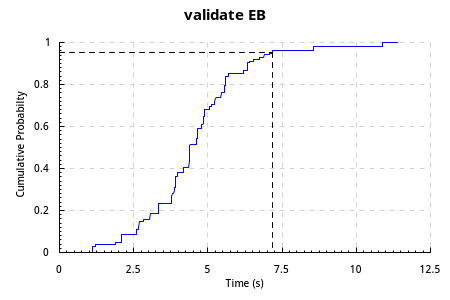

In [37]:
toRenderable $ plotCDFWithQuantiles "validate EB" [0.95] validateEB

**FIXME**: A `DQ` constructed as above suffers from bad performance, as the convolution in the *piecewise polynomial* implemenation produces too many pieces, see also https://github.com/DeltaQ-SD/deltaq/issues/134. Therefore, for now I'm just using a fixed distribution for `validateEB`, see below. 

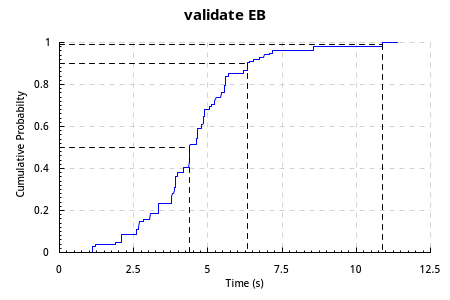

In [38]:
toRenderable $ plotCDFWithQuantiles "validate EB" [0.5, 0.9, 0.99] validateEB 

In [39]:
complexity fetchingTxs

3

## Questions to ask

* There's an RB with an EB. What is the probablity that the next RB has a certificate for the EB?
* Probability to be in the voting committee, resp. probability that votes get delivered on-time. What are the preconditions? What are the different scenarios to be considered? Probability of a quorum? ✅ see pQuorum below
* Will there be a fork of the Praos chain, if the slot leader has not received the EB corresponding to a certificate in an RB that the slot leader is supposed to extend? EB diffusion would affect the Praos chain behaviour?
* What is the probability that a transaction is not known, i.e., needs to be fetched explicitly? Model tx diffusion ✅ mempool model, see above

### Probability of certificate in next RB

### [Step 1: Block Production](https://github.com/cardano-scaling/CIPs/tree/leios/CIP-0164#step-1-block-production)

The poisson schedule for the block production implies that the waiting time for the next block is exponentially distributed with lambda (active slot coefficient)

In [40]:
praosBlockDistr :: ExponentialDistribution
praosBlockDistr = exponential lambda

### [Step 2: EB Distribution](https://github.com/cardano-scaling/CIPs/tree/leios/CIP-0164#step-2-eb-distribution)

### [Step 3: Committee Validation](https://github.com/cardano-scaling/CIPs/tree/leios/CIP-0164#step-3-committee-validation)

1. The RB header arrived within $L_\text{hdr}$,

In [41]:
pHeaderOnTime :: Probability DQ
pHeaderOnTime = successWithin emitRBHeader lHdr 

In [42]:
fromRational pHeaderOnTime

0.8099036735360926

2. It has **not** detected any equivocating RB header for the same slot,
3. It finished validating the EB before $3 \times L_\text{hdr} + L_\text{vote}$
   slots after the EB slot,

In [43]:
pValidating :: Probability DQ
pValidating = successWithin validateEB (3*lHdr + lVote)

In [44]:
fromRational pValidating

0.9430771415678038

In [45]:
stakeDistribution :: [Double]
stakeDistribution = map f [0,1..nPools]
  where f k = ((k+1)/nPools)**10 - (k/nPools)**10

In [46]:
bisectionSearch :: (Double -> Double) -> Double -> Double -> Double -> Integer -> Double
bisectionSearch f low high eps 0 = (low + high) / 2
bisectionSearch f low high eps maxIter = 
  let mid = (low + high) / 2
  in 
    if high - low < eps || abs (f mid) < eps then mid
    else if f low * f mid < 0 then bisectionSearch f low mid eps (maxIter-1)
    else bisectionSearch f mid high eps (maxIter-1)

In [47]:
calibrateCommittee :: Double -> Double
calibrateCommittee m = 
  let f x = sum (map (\s -> 1 - exp (- x * s)) stakeDistribution) - m
  in bisectionSearch f m nPools 0.5 10

In [48]:
committeeDistribution :: Double -> Double -> (Double, Double)
committeeDistribution pSuccessfulVote m =
  let m' = calibrateCommittee m
      ps = map (\s -> pSuccessfulVote * (1 - exp (- m' * s))) stakeDistribution
      μ  = sum ps
      σ  = sqrt $ sum $ map (\p -> p * (1 - p)) ps
  in (μ , σ) 

In [49]:
pQuorum :: Double -> Double -> Double -> Double
pQuorum pSuccessfulVote m τ =
  let (μ , σ) = committeeDistribution pSuccessfulVote m
  in complCumulative (normalDistr μ σ) (τ * m) 

In [50]:
pQuorum (0.9*0.95) 600 0.75

0.9999989324889966

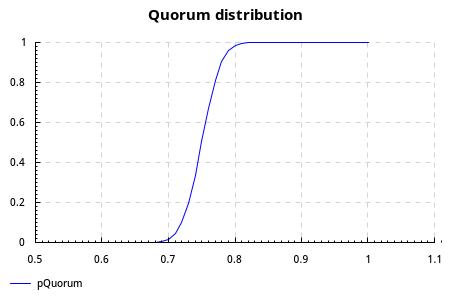

In [51]:
toRenderable $ 
    let xs = [0.50,0.51..1]
        vs = [(x, pQuorum x 600 0.75) | x <- xs]
    in do 
        layout_title .= "Quorum distribution"
        plot (line "pQuorum" [vs])

In [ ]:
pQ = pQuorum (fromRational $ successWithin validateEB (3*lHdr + lVote)) 600 0.75
printf "Probability of Quorum: %.2f" pQ

Probability of Quorum: 1.00

4. The EB is the one announced by the latest RB in the voter's current chain,
5. The EB's transactions form a **valid** extension of the RB that announced it,
6. For non-persistent voters, it is eligible to vote based on sortition using
   the announcing RB's slot number as the election identifier,
7. The EB contains at least one transaction (i.e., is not empty), as specified
   in the [formal specification][leios-formal-spec-empty-eb].

### [Step 4: Certification](https://github.com/cardano-scaling/CIPs/tree/leios/CIP-0164#step-4-certification)


During the voting period, if enough committee votes are collected such that the
total stake exceeds a **high threshold** parameter ($\tau$), for example 75%,
the EB becomes **certified**:

$$
\sum_{v \in \text{votes}} \text{stake}(v) \geq \tau \times \text{stake}_{\text{total-active}}
$$

**TODO: Probability that the elected members of the committee received the EB**

### [Step 5: Chain Inclusion](https://github.com/cardano-scaling/CIPs/tree/leios/CIP-0164#step-5-chain-inclusion)

1. `RB'` **may** include a certificate for the EB announced in `RB` if and only
   if `RB'` is at least $3 \times L_\text{hdr} + L_\text{vote} + L_\text{diff}$
   slots after `RB`.

In [ ]:
pBlock = cumulative praosBlockDistr (3*lHdr + lVote + lDiff)
printf "Probability that the next Praos block has already been produced after the waiting period: %.4f" pBlock

Probability that the next Praos block has already been produced after the waiting period: 0.5034

2. Any included certificate must be valid as defined in
   [Certificate Validation](#certificate-validation).

3. If `RB'` cannot include a certificate due to timing constraints (i.e., fewer
   than $3 \times L_\text{hdr} + L_\text{vote} + L_\text{diff}$ slots have
   elapsed since `RB`), then `RB'` operates as a standard Praos block containing
   its own transactions, and the EB announced by `RB` is discarded.

4. Regardless of whether `RB'` includes a certificate, it may optionally
   announce its own EB for future certification by subsequent blocks.